# Thorium Calibration

We simulate a thorium mantle attached next to the tank. We calculate the expected spectrum for the energy deposition as well as the rate of incidence.

In [1]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import parallel, concat
from tqdm.notebook import tqdm

%matplotlib widget

# Reading the files

In [2]:
# Read the files

# Parameters
header                  = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy', 'Origin Volume', 'MigrantID']

# Find the files
foldername  = f'../build/output'
os.system(f'rm -rf ../build/output/.ipynb_checkpoints')
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def loadFile(filename):
    df = pd.read_csv(os.path.join(foldername,filename),skiprows=16,names=header)
    df.insert(0, 'Filename', filename)
    return df

loadFiles = parallel(loadFile)

if __name__ == '__main__':
    files = loadFiles(filenames)

Found 1024 data files in ../build/output


  0%|          | 0/1024 [00:00<?, ?it/s]

In [3]:
# Function to extract the energy deposited per track
def getEnergy(data):
    return data.groupby(['Filename','EventID','TrackID','Particle', 'MigrantID'])[['EnergyDeposited', 'Initial Energy']].sum().reset_index()

getEnergies = concat(parallel(getEnergy))

# Get the incoming energy of the particles

# Get the deposited energies
energy = getEnergies(files)

# Split into the energy per particle
particleEnergies = {particle:energy.loc[energy.Particle == particle] for particle in energy.Particle.unique()}

  0%|          | 0/1024 [00:00<?, ?it/s]

# Creating a gamma emission spectrum of throium

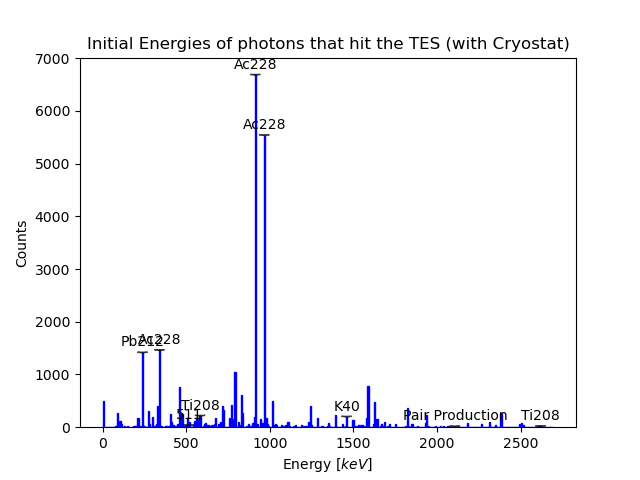

In [5]:
def annotate_peaks(ax, x_values, y_values, labels):
    for x, y, label in zip(x_values, y_values, labels):
        ax.annotate(label, xy=(x, y), xytext=(x, y + 200),  # Adjust xytext to control the label position
                    arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', alpha=0.7),
                    horizontalalignment='center', verticalalignment='center')



x_irl = [238.6, 338.3, 511, 583.2, 911.2, 968.9, 1460, 2103, 2614.5]
material_names = ['Pb212', 'Ac228', '511', 'Ti208', 'Ac228', 'Ac228', 'K40', 'Pair Production', 'Ti208']
gamma = energy[(energy['Particle'] == 'gamma') & (energy['MigrantID'] == -1)]
gamma = gamma[gamma['Initial Energy'] < 2700]

plt.clf()
fig, ax = plt.subplots()
counts, bin_edges, patches = ax.hist(gamma['Initial Energy'], bins = 400, color = 'b', edgecolor = 'blue')
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

x_sim = []

for x in x_irl:
    try:
        x_sim.append(max([i for i in bin_centers if abs(x-i) < 5.]))
    except:
        pass
    
y_sim = []
for x,y in zip(bin_centers, counts):
    if x in x_sim:
        y_sim.append(y)




# plt.xscale('log')
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=100))
# ax.set_xlim(1,2700)
ax.set_xlabel('Energy [$keV$]')
ax.set_ylabel('Counts')
ax.set_yscale('linear')
ax.set_title('Initial Energies of photons that hit the TES (with Cryostat)')
annotate_peaks(ax, x_sim, y_sim, material_names)
plt.show()

In [26]:
data = pd.concat(files)
data

,Filename,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID
0,TES-run0-rank753_nt_hits.csv,2641,17,gamma,0.0,-47.5000,-370.028,-11.60070,0.912777,physSiliconSubstrate,911.209,physicalThorium,-1
1,TES-run0-rank753_nt_hits.csv,5395,38,anti_nu_e,0.0,-47.5000,-366.651,-9.91343,0.877267,physSiliconSubstrate,165.612,physicalThorium,-1
2,TES-run0-rank753_nt_hits.csv,5529,14,anti_nu_e,0.0,-44.9252,-371.000,-8.69687,0.896077,physSiliconSubstrate,345.994,physicalThorium,-1
3,TES-run0-rank753_nt_hits.csv,10534,11,anti_nu_e,0.0,-43.3841,-371.000,-9.01464,0.859846,physSiliconSubstrate,529.593,physicalThorium,-1
4,TES-run0-rank753_nt_hits.csv,12358,33,anti_nu_e,0.0,-47.5000,-367.186,-10.20080,0.898370,physSiliconSubstrate,328.211,physicalThorium,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,TES-run0-rank264_nt_hits.csv,949333,17,gamma,0.0,-47.5000,-370.576,-12.20460,0.904553,physSiliconSubstrate,911.209,physicalThorium,-1
201,TES-run0-rank264_nt_hits.csv,956460,14,anti_nu_e,0.0,-47.5000,-366.864,-8.36061,0.894002,physSiliconSubstrate,883.607,physicalThorium,-1
202,TES-run0-rank264_nt_hits.csv,958208,34,anti_nu_e,0.0,-42.8963,-371.000,-8.41949,0.857504,physSiliconSubstrate,723.068,physicalThorium,-1
203,TES-run0-rank264_nt_hits.csv,973979,44,anti_nu_e,0.0,-47.5000,-369.040,-8.43910,0.895695,physSiliconSubstrate,1892.310,physicalThorium,-1


# Finding Spectra

In [7]:
data = pd.concat(files)
data = data.groupby(['Filename','EventID','TrackID','Particle', 'Origin Volume', 'MigrantID'])['EnergyDeposited'].sum().reset_index()
data

,Filename,EventID,TrackID,Particle,Origin Volume,MigrantID,EnergyDeposited
0,TES-run0-rank0_nt_hits.csv,4402,10,anti_nu_e,physicalThorium,-1,0.0
1,TES-run0-rank0_nt_hits.csv,5254,40,anti_nu_e,physicalThorium,-1,0.0
2,TES-run0-rank0_nt_hits.csv,25633,30,anti_nu_e,physicalThorium,-1,0.0
3,TES-run0-rank0_nt_hits.csv,26527,11,anti_nu_e,physicalThorium,-1,0.0
4,TES-run0-rank0_nt_hits.csv,37605,23,gamma,physicalThorium,-1,0.0
...,...,...,...,...,...,...,...
135758,TES-run0-rank9_nt_hits.csv,942893,17,gamma,physicalThorium,-1,0.0
135759,TES-run0-rank9_nt_hits.csv,946907,11,anti_nu_e,physicalThorium,-1,0.0
135760,TES-run0-rank9_nt_hits.csv,951389,10,anti_nu_e,physicalThorium,-1,0.0
135761,TES-run0-rank9_nt_hits.csv,966313,35,anti_nu_e,physicalThorium,-1,0.0


In [12]:
originInside = data[data['Origin Volume'].str.contains('Silicon')]
originInside = originInside.drop(columns = ['TrackID', 'Particle','Origin Volume'])
originInside = originInside.rename(columns = {'MigrantID':'TrackID', 'EnergyDeposited':'EnergyFromInside'})
originInside

,Filename,EventID,TrackID,EnergyFromInside
17,TES-run0-rank0_nt_hits.csv,183653,19,0.040420
50,TES-run0-rank0_nt_hits.csv,416181,23,0.019258
57,TES-run0-rank0_nt_hits.csv,454438,19,0.138696
76,TES-run0-rank0_nt_hits.csv,573183,16,0.011894
77,TES-run0-rank0_nt_hits.csv,573183,16,0.033824
...,...,...,...,...
135490,TES-run0-rank99_nt_hits.csv,37847,16,0.028339
135509,TES-run0-rank99_nt_hits.csv,151863,23,0.036698
135613,TES-run0-rank99_nt_hits.csv,955517,22,0.014357
135620,TES-run0-rank9_nt_hits.csv,20369,24,0.030847


In [13]:
originOutside = data[~(data['Origin Volume'].str.contains('Silicon'))]
originOutside = originOutside.drop(columns = ['Origin Volume','MigrantID'])
originOutside = originOutside.rename(columns = {'EnergyDeposited':'EnergyFromOutside'})
originOutside

,Filename,EventID,TrackID,Particle,EnergyFromOutside
0,TES-run0-rank0_nt_hits.csv,4402,10,anti_nu_e,0.0
1,TES-run0-rank0_nt_hits.csv,5254,40,anti_nu_e,0.0
2,TES-run0-rank0_nt_hits.csv,25633,30,anti_nu_e,0.0
3,TES-run0-rank0_nt_hits.csv,26527,11,anti_nu_e,0.0
4,TES-run0-rank0_nt_hits.csv,37605,23,gamma,0.0
...,...,...,...,...,...
135758,TES-run0-rank9_nt_hits.csv,942893,17,gamma,0.0
135759,TES-run0-rank9_nt_hits.csv,946907,11,anti_nu_e,0.0
135760,TES-run0-rank9_nt_hits.csv,951389,10,anti_nu_e,0.0
135761,TES-run0-rank9_nt_hits.csv,966313,35,anti_nu_e,0.0


In [14]:
combined = pd.merge(originOutside, originInside, on = ['Filename','EventID', 'TrackID'], how = 'left').fillna(0)
combined['EnergyDeposited'] = combined['EnergyFromOutside'] + combined['EnergyFromInside']
combined = combined[combined['EnergyDeposited'] > 0.0]
combined

,Filename,EventID,TrackID,Particle,EnergyFromOutside,EnergyFromInside,EnergyDeposited
16,TES-run0-rank0_nt_hits.csv,183653,19,gamma,0.000007,0.040420,0.040426
48,TES-run0-rank0_nt_hits.csv,416181,23,gamma,0.000152,0.019258,0.019410
54,TES-run0-rank0_nt_hits.csv,454438,19,gamma,0.000152,0.138696,0.138847
72,TES-run0-rank0_nt_hits.csv,573183,16,gamma,0.000165,0.011894,0.012059
73,TES-run0-rank0_nt_hits.csv,573183,16,gamma,0.000165,0.033824,0.033989
...,...,...,...,...,...,...,...
132405,TES-run0-rank99_nt_hits.csv,37847,16,gamma,0.000014,0.028339,0.028353
132423,TES-run0-rank99_nt_hits.csv,151863,23,gamma,0.000007,0.036698,0.036705
132526,TES-run0-rank99_nt_hits.csv,955517,22,gamma,0.000152,0.014357,0.014509
132532,TES-run0-rank9_nt_hits.csv,20369,24,gamma,0.001829,0.030847,0.032675


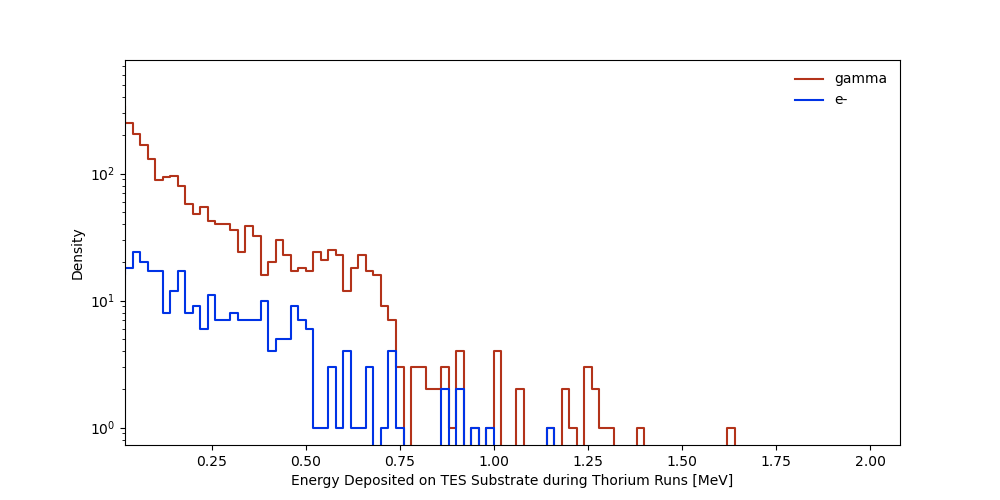

In [15]:
particleEnergies = {particle:combined.loc[combined.Particle == particle] for particle in combined.Particle.unique()}
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 100
LIMS        = (0,2)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].EnergyDeposited,bins=BINS)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

ax.set_xlim(BINS[1],None)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs [MeV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
ax.set_yscale('log')
# ax.set_xscale('log')

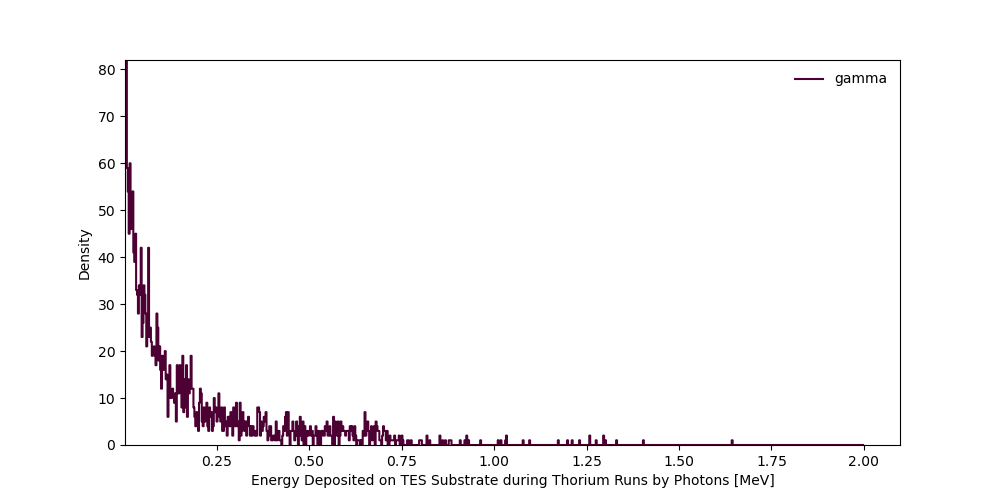

In [16]:
gamma = combined[combined['Particle'] == 'gamma']

# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 800
LIMS        = (0,2)
BINS        = np.linspace(*LIMS,NBINS+1)
PARTICLE    = 'gamma'
stackedHist = np.histogram(gamma.EnergyDeposited,bins=BINS)[0]
color       = np.round(np.random.rand(len(stackedHist),3),1)
ax.step(BINS[:-1],stackedHist,label=PARTICLE,color=color[0])

ax.set_xlim(BINS[1],None)
ax.set_ylim(0,np.max(stackedHist[1:]))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs by Photons [MeV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')

In [18]:
# check that there are no overlaps
clearData = pd.concat(files)

clearData = clearData.groupby(['Filename','EventID', 'TrackID', 'Particle'])['EnergyDeposited'].sum().reset_index()
clearData
unclearData = clearData.groupby(['Filename','EventID', 'TrackID']).count()
unclearData = unclearData[unclearData['Particle'] > 1]
unclearData = unclearData.drop(columns = ['EnergyDeposited'])
unclearData
overlaps = pd.merge(clearData, unclearData, on = ['EventID', 'TrackID'])
overlaps = overlaps.rename(columns = {'Particle_y':'Count'})
overlaps

,Filename,EventID,TrackID,Particle_x,EnergyDeposited,Count
